## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
# import tensorflow as tf
# from tensorflow import keras

# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# import tensorflow.compat.v2.feature_column as fc

# #!pip install -q git+https://github.com/tensorflow/docs

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

#print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v5

# from utils.models import make_input_fn
# from utils.models import performanceTesting,scoreFunction
# from utils.plotting import plot_confusion_matrix

C:\Users\PC\AppData\Local\Temp\tmp2jialnko\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


In [3]:
files = os.listdir('../AzureML/Output_from_cloud')
files

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'hyperparameters_lr_v3.txt',
 'hyperparameters_nn.txt',
 'hyperparameters_nn_v4.txt',
 'metrics.txt',
 'metrics_lr_v1.txt',
 'metrics_lr_v2.txt',
 'metrics_lr_v3.txt',
 'metrics_nn.txt',
 'metrics_nn_v4.txt']

In [7]:
hyperfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('hyper' in i) & ('nn' in i)]
metricfiles_nn = [i for i in os.listdir('../AzureML/Output_from_cloud') if ('metric' in i) & ('nn' in i)]

# Loading Neural Network

## Hyperparameters

In [29]:
### Reading in the file

with open('../AzureML/Output_from_cloud/'+hyperfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers for the data
all_ids = []
all_parameters = []

## Going over each line in the text file
for a in np.arange(len(content[0:-1])):
    
    ## Split the lines on tabs
    temp_parameters = re.split('[\t]',content[a])[1]
    
    ## Basic string cleaning, i.e. removing redundant characters
#     test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
#                                                                        .replace('}','')\
#                                                                        .replace('\n','')\
#                                                                        .replace('"',''))]
    test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')
                                                                       .replace('\'',''))]
    
    ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
    ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
    test = {i[0]:i[1] for i in test}
    
    # Constructing the dataframe
    if a == 0:
        parameters = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])
    
    else:
        
        parameters.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)

In [13]:
content[0]

"HD_81ace623-e09b-4393-8a5e-131ea8749a35_999\t{'--activation-inner': 'tanh', '--activation-output': 'softmax', '--batch-norm': '0', '--batch-shuffle': '0', '--batch-size': '21450', '--dropout-ratio': '0.2', '--feature-lags': '0', '--featureset': '1', '--first-layer-neurons': '128', '--label-type': '1', '--learning-rate': '0.0001', '--n-epochs': '150', '--n-layers': '4', '--nn-type': 'lstm', '--pastobs-in-percentage': '1', '--pre-processing': 'quantgau', '--second-layer-neurons': '32'}\n"

In [10]:
len(content)

1001

In [28]:
[re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                       .replace('}','')\
                                                                       .replace('\n','')\
                                                                       .replace('"','')\
                                                                       .replace('--','')
                                                                       .replace('\'',''))]

[['activation-inner', 'sigmoid'],
 ['activation-output', 'linear'],
 ['batch-norm', '0'],
 ['batch-shuffle', '1'],
 ['batch-size', '21450'],
 ['dropout-ratio', '0.1'],
 ['feature-lags', '1'],
 ['featureset', '1'],
 ['first-layer-neurons', '64'],
 ['label-type', '1'],
 ['learning-rate', '0.1'],
 ['n-epochs', '150'],
 ['n-layers', '3'],
 ['nn-type', 'ffnn'],
 ['pastobs-in-percentage', '1'],
 ['pre-processing', 'stacked'],
 ['second-layer-neurons', '64']]

In [30]:
parameters

,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,label-type,learning-rate,n-epochs,n-layers,nn-type,pastobs-in-percentage,pre-processing,second-layer-neurons
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999,tanh,softmax,0,0,21450,0.2,0,1,128,1,0.0001,150,4,lstm,1,quantgau,32
HD_81ace623-e09b-4393-8a5e-131ea8749a35_998,sigmoid,softmax,0,0,21450,0.3,5,3,128,2,0.001,150,2,lstm,0,stacked,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_997,relu,linear,1,1,10725,0.5,3,2,64,3,0.0001,150,2,lstm,0,pow,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_996,sigmoid,softmax,1,1,10725,0,3,0,64,1,0.01,150,4,ffnn,1,std,64
HD_81ace623-e09b-4393-8a5e-131ea8749a35_994,tanh,softmax,1,1,3300,0.2,1,0,128,1,0.0001,150,4,ffnn,1,std,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HD_81ace623-e09b-4393-8a5e-131ea8749a35_9,leakyrelu,linear,0,1,3300,0.4,0,3,128,2,0.1,150,3,ffnn,1,pow,32
HD_81ace623-e09b-4393-8a5e-131ea8749a35_7,tanh,linear,0,1,10725,0.1,3,0,64,0,0.0001,150,1,ffnn,1,minmax,128
HD_81ace623-e09b-4393-8a5e-131ea8749a35_5,leakyrelu,softmax,1,1,21450,0.5,3,3,128,2,0.01,150,2,lstm,0,quantgau,128
HD_81ace623-e09b-4393-8a5e-131ea8749a35_6,relu,softmax,0,0,21450,0.2,1,1,32,4,0.001,150,1,lstm,0,stacked,32


In [34]:
parameters.iloc[115,:]

activation-inner         sigmoid
activation-output        softmax
batch-norm                     1
batch-shuffle                  1
batch-size                 10725
dropout-ratio                0.1
feature-lags                   3
featureset                     3
first-layer-neurons          128
label-type                     2
learning-rate               0.01
n-epochs                     150
n-layers                       4
nn-type                     lstm
pastobs-in-percentage          0
pre-processing               std
second-layer-neurons          32
Name: HD_81ace623-e09b-4393-8a5e-131ea8749a35_883, dtype: object

## Metrics

In [35]:
## Readidng in the file
with open('../AzureML/Output_from_cloud/'+metricfiles_nn[-1],'r') as file:
    content = file.readlines()

## Containers
t11 = []
t12 = []
t13 = []

t21 = []
t22 = []
t23 = []

## Going over each line
for i in np.arange(len(content)):#
    
    ## Split each line on tabs
    temp = re.split('\t',content[i].replace('\n',''))
    
    #print(temp)
    
    ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
    ## and 2. a time series of a metric for each model.
    
    ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
    ## It stored separately for the time series.
    if len(temp[2]) < 50:

        t11.append(temp[0])
        t12.append(temp[1])
        t13.append(temp[2])
    
    ## Time series
    else:
    
        container = np.zeros(155)
        temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

        container[0:len(temp1)] = temp1
        container[len(temp1):] = temp1[-1]

        t21.append(temp[0])
        t22.append(temp[1])
        t23.append(container)        

## Storing the time series in a dataframe
arrays = [t21,t22]
tuples = list(zip(*arrays))

runningMetrics = pd.DataFrame(np.array(t23),
                              index=pd.MultiIndex.from_tuples(tuples),
                              columns = [np.arange(155).astype(str)]
                             )
## Storing the final metrics in a dataframe.
arrays = [t11,t12]
tuples = list(zip(*arrays))
finalMetrics = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])

In [36]:
finalMetrics

size
HD_81ace623-e09b-4393-8a5e-131ea8749a35_998 Final test loss      0.8833522492045336
                                            Final test AUC       0.7648658156394958
                                            Final test accuracy  0.6109746098518372
HD_81ace623-e09b-4393-8a5e-131ea8749a35_996 Final test loss      1.1133369887535414
                                            Final test AUC        0.640163779258728
...                                                                             ...
HD_81ace623-e09b-4393-8a5e-131ea8749a35_5   Final test AUC       0.7837895154953003
                                            Final test accuracy   0.602816104888916
HD_81ace623-e09b-4393-8a5e-131ea8749a35_6   Final test loss      1.3713646207894699
                                            Final test AUC       0.7241190671920776
                                            Final test accuracy  0.4148908853530884

[1170 rows x 1 columns]

In [37]:
finalMetrics.iloc[957:963,:]

size
HD_81ace623-e09b-4393-8a5e-131ea8749a35_116 Final test loss       0.6772750117269136
                                            Final test AUC        0.5715229511260986
                                            Final test accuracy   0.5456066727638245
HD_81ace623-e09b-4393-8a5e-131ea8749a35_115 Final test loss        1.052469070279928
                                            Final test AUC        0.6014689207077026
                                            Final test accuracy  0.42372506856918335

In [38]:
finalMetrics.shape

(1170, 1)

In [39]:
runningMetrics

0  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Loss            1.098537   
                                            Accuracy        0.354843   
                                            AUC             0.500120   
                                            Train Loss      1.098558   
                                            Train Accuracy  0.344181   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Accuracy        0.337729   
                                            AUC             0.006679   
                                            Train Loss      5.383223   
                                            Train Accuracy  0.333057   
                                            Train AUC       0.030584   

                                                                   1  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Loss            1.098504   
                                            Accuracy        0.358482   
                                            AUC             0.500277   
                                            Train Loss      1.098524   
                                            Train Accuracy  0.350251   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Accuracy        0.337729   
                                            AUC             0.003153   
                                            Train Loss      5.355752   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.004384   

                                                                   2  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Loss            1.098467   
                                            Accuracy        0.362843   
                                            AUC             0.500545   
                                            Train Loss      1.098487   
                                            Train Accuracy  0.353537   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Accuracy        0.337729   
                                            AUC             0.002064   
                                            Train Loss      5.355751   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.002511   

                                                                   3  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Loss            1.098423   
                                            Accuracy        0.365199   
                                            AUC             0.501018   
                                            Train Loss      1.098442   
                                            Train Accuracy  0.358348   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Accuracy        0.337729   
                                            AUC             0.001534   
                                            Train Loss      5.355751   
                                            Train Accuracy  0.332281   
                                            Train AUC       0.001766   

                                                                   4  \
HD_81ace623-e09b-4393-8a5e-131ea8749a35_999 Loss            1.098371   
                                            Accuracy        0.366960   
                                            AUC             0.501737   
                                            Train Loss      1.098396   
                                            Train Accuracy  0.360740   
...                                                              ...   
HD_81ace623-e09b-4393-8a5e-131ea8749a35_1   Accuracy        0.337729   
                               

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [40]:
## Resetting indcies and rename columns
runningMetrics = runningMetrics.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics.columns = runningMetrics.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics['id'] = [re.split('_',i)[-1] for i in runningMetrics.run_id]

## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table = pd.pivot_table(runningMetrics[['run_id','metric','154','id']],index='id',columns=['metric'])
table.columns = table.columns.get_level_values(1)
table = table.round(5).reset_index()

## Preparing the parameter dataframe.
parameters = parameters.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters['id'] = [re.split('_',i)[-1] for i in parameters.run_id]

## Creating the combined table
combined_table = parameters.merge(table,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
115,HD_81ace623-e09b-4393-8a5e-131ea8749a35_883,sigmoid,softmax,1,1,10725,0.1,3,3,128,...,0,std,32,883,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
781,HD_81ace623-e09b-4393-8a5e-131ea8749a35_218,tanh,softmax,1,0,21450,0,5,1,64,...,0,pow,32,218,0.79064,0.57710,0.99908,0.79060,0.65135,0.80627
997,HD_81ace623-e09b-4393-8a5e-131ea8749a35_5,leakyrelu,softmax,1,1,21450,0.5,3,3,128,...,0,quantgau,128,5,0.78380,0.60282,0.90322,0.78376,0.62677,0.84667
928,HD_81ace623-e09b-4393-8a5e-131ea8749a35_72,tanh,softmax,1,1,3300,0.2,3,3,128,...,1,stacked,64,72,0.78185,0.61228,0.89609,0.78181,0.62734,0.84895
128,HD_81ace623-e09b-4393-8a5e-131ea8749a35_871,tanh,softmax,1,1,10725,0,3,0,128,...,0,quantgau,32,871,0.78175,0.60582,0.92492,0.78172,0.62636,0.85098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,HD_81ace623-e09b-4393-8a5e-131ea8749a35_185,relu,linear,0,1,3300,0.3,5,3,128,...,1,None,128,185,0.00000,0.19641,0.94736,0.00000,0.19952,0.95143
304,HD_81ace623-e09b-4393-8a5e-131ea8749a35_695,sigmoid,linear,0,0,3300,0.1,1,3,64,...,1,quantgau,128,695,0.00000,0.19329,0.89643,0.00000,0.18706,0.91432
195,HD_81ace623-e09b-4393-8a5e-131ea8749a35_803,tanh,linear,0,0,21450,0.3,3,0,32,...,1,minmax,32,803,0.00000,0.45457,0.68465,0.00000,0.45333,0.68717
861,HD_81ace623-e09b-4393-8a5e-131ea8749a35_137,sigmoid,linear,0,1,10725,0.5,5,3,128,...,0,stacked,64,137,0.00000,0.16547,1.59072,0.00000,0.17433,1.59977


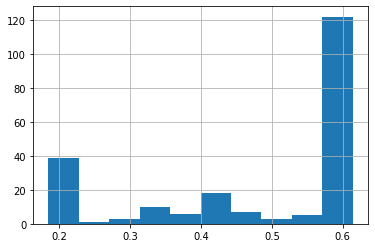

In [41]:
runningMetrics[(runningMetrics.metric=='Accuracy')&\
               (np.isin(runningMetrics.id,parameters[parameters['label-type']=='2'].id.values))].sort_values('154')['154'].hist()

In [42]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc = pd.pivot_table(combined_table[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc = pd.pivot_table(combined_table[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc = pd.DataFrame(np.sort(temp_auc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc = pd.DataFrame(np.sort(temp_acc.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc.columns.get_level_values(1))#.loc[0:10]
# final_output

In [43]:
list(combined_table.columns)

['run_id',
 'activation-inner',
 'activation-output',
 'batch-norm',
 'batch-shuffle',
 'batch-size',
 'dropout-ratio',
 'feature-lags',
 'featureset',
 'first-layer-neurons',
 'label-type',
 'learning-rate',
 'n-epochs',
 'n-layers',
 'nn-type',
 'pastobs-in-percentage',
 'pre-processing',
 'second-layer-neurons',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

In [44]:
tempFinal_v0 = combined_table[np.isin(combined_table.AUC,final_output_auc.loc[0].values.flatten())]
tempFinal_v0.index = tempFinal_v0.loc[:,'label-type']
tempFinal_v0

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_883,sigmoid,softmax,1,1,10725,0.1,3,3,128,...,0,std,32,883,0.80363,0.58075,0.98257,0.80358,0.66548,0.77074
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_743,relu,softmax,1,0,10725,0,3,3,128,...,1,std,32,743,0.75291,0.39708,1.49211,0.75284,0.46585,1.25437
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_65,leakyrelu,softmax,0,1,10725,0,5,1,128,...,0,std,64,65,0.74085,0.38183,1.54324,0.74076,0.63645,0.77408
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_818,relu,softmax,1,1,10725,0,5,1,128,...,1,pow,128,818,0.71117,0.53313,0.97092,0.71096,0.74884,0.49957
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_737,tanh,softmax,1,1,3300,0,5,0,32,...,0,pow,128,737,0.68440,0.27445,1.66672,0.68431,0.41546,1.36253


In [45]:
tempFinal_v0.loc['1']

run_id                   HD_81ace623-e09b-4393-8a5e-131ea8749a35_65
activation-inner                                          leakyrelu
activation-output                                           softmax
batch-norm                                                        0
batch-shuffle                                                     1
batch-size                                                    10725
dropout-ratio                                                     0
feature-lags                                                      5
featureset                                                        1
first-layer-neurons                                             128
label-type                                                        1
learning-rate                                                  0.01
n-epochs                                                        150
n-layers                                                          4
nn-type                                         

In [46]:
tempFinal_v1 = combined_table[np.isin(combined_table.Accuracy,final_output_acc.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1.index = tempFinal_v1.loc[:,'label-type']
tempFinal_v1

,run_id,activation-inner,activation-output,batch-norm,batch-shuffle,batch-size,dropout-ratio,feature-lags,featureset,first-layer-neurons,...,pastobs-in-percentage,pre-processing,second-layer-neurons,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,,
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_706,leakyrelu,softmax,0,0,10725,0.4,1,3,64,...,0,quantgau,128,706,0.57765,0.55382,0.67447,0.57746,0.55565,0.67536
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_390,leakyrelu,softmax,1,0,10725,0.5,0,3,128,...,1,pow,64,390,0.62001,0.43072,1.04843,0.61998,0.44065,1.04593
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_283,tanh,softmax,1,1,3300,0.1,3,2,32,...,0,stacked,128,283,0.76304,0.61409,0.87683,0.76298,0.61164,0.87896
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_213,tanh,softmax,0,1,21450,0.5,5,0,128,...,1,pow,64,213,0.64187,0.30243,1.51325,0.64186,0.30381,1.51441
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_528,tanh,softmax,1,1,10725,0.1,3,0,128,...,0,std,32,528,0.73196,0.42030,1.35104,0.73192,0.41582,1.35792


In [47]:
list(combined_table.columns)

['run_id',
 'activation-inner',
 'activation-output',
 'batch-norm',
 'batch-shuffle',
 'batch-size',
 'dropout-ratio',
 'feature-lags',
 'featureset',
 'first-layer-neurons',
 'label-type',
 'learning-rate',
 'n-epochs',
 'n-layers',
 'nn-type',
 'pastobs-in-percentage',
 'pre-processing',
 'second-layer-neurons',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

## An example of a box-plot

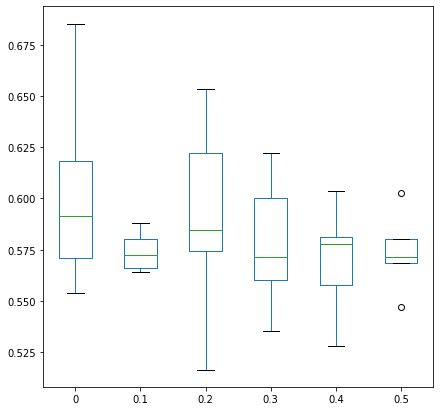

In [48]:
temp = combined_table[(combined_table.loc[:,'label-type']=='0')&(combined_table.loc[:,'nn-type']=='lstm')&(combined_table.AUC>0.5)]
temp_2 = pd.pivot_table(temp,values='AUC',columns='dropout-ratio',index='run_id').reset_index()
temp_2.boxplot(list(temp_2.columns[1:]),figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

In [49]:
cols_not_plot = []
cols_to_plot = []

for i,col in enumerate(temp.columns):
    if (temp.loc[:,col].unique().shape[0]>1)&(temp.loc[:,col].unique().shape[0]<7):
        cols_to_plot.append(col)
        print(col,': ',temp.loc[:,col].unique(),'\n')
    else:
        cols_not_plot.append(col)

activation-inner :  ['tanh' 'sigmoid' 'relu' 'leakyrelu'] 

activation-output :  ['softmax' 'linear'] 

batch-norm :  ['1' '0'] 

batch-shuffle :  ['1' '0'] 

batch-size :  ['21450' '10725' '3300'] 

dropout-ratio :  ['0' '0.2' '0.3' '0.4' '0.5' '0.1'] 

feature-lags :  ['5' '3' '0' '1'] 

featureset :  ['0' '3' '2' '1'] 

first-layer-neurons :  ['128' '64' '32'] 

learning-rate :  ['0.01' '0.1' '0.001' '0.0001'] 

n-layers :  ['4' '1' '2' '3'] 

pastobs-in-percentage :  ['1' '0'] 

pre-processing :  ['pow' 'quantgau' 'minmax' 'std' 'None' 'stacked'] 

second-layer-neurons :  ['32' '64' '128'] 



In [50]:
len(cols_to_plot)

14

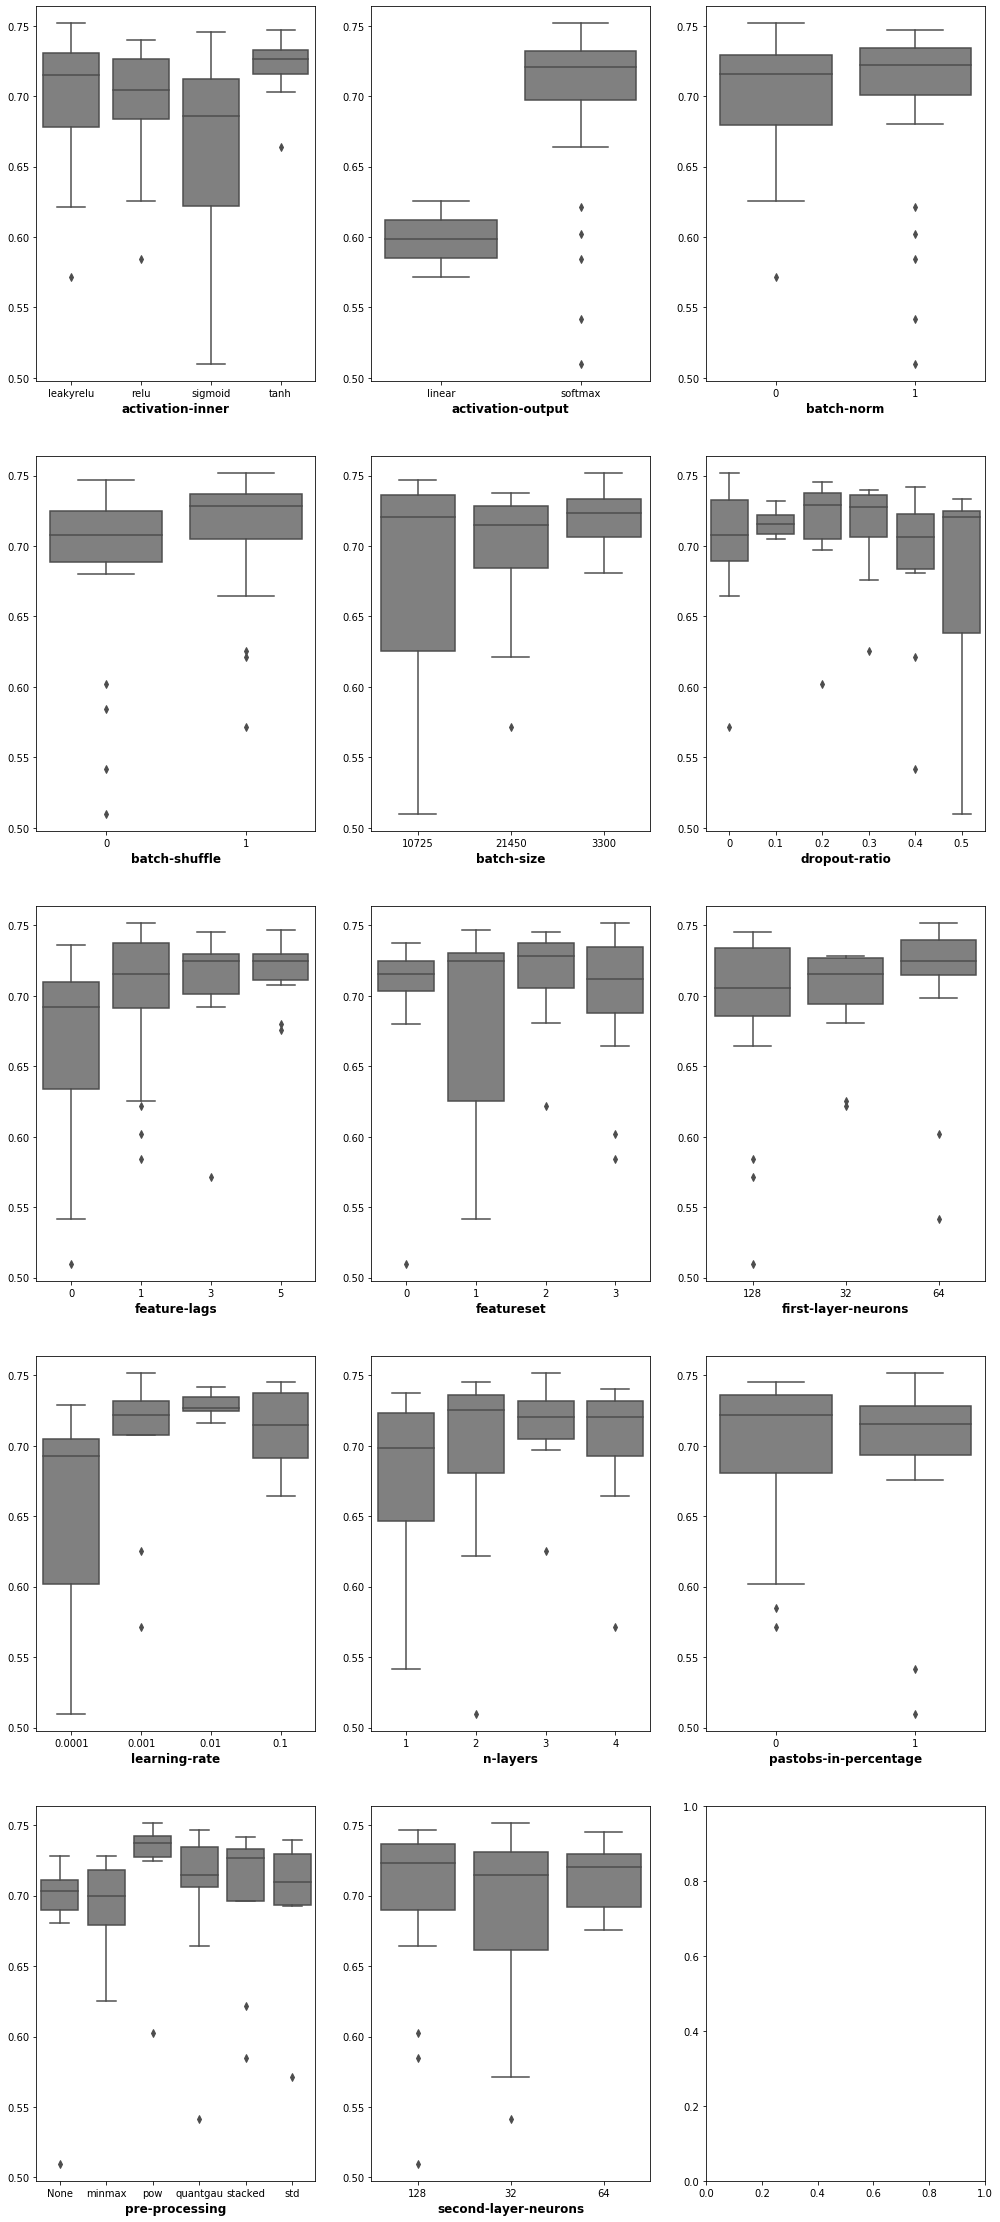

In [51]:
import seaborn as sns

temp = combined_table[(combined_table.loc[:,'label-type']=='4')&(combined_table.loc[:,'nn-type']=='ffnn')&(combined_table.AUC>0.5)]

fig,ax = plt.subplots(5,3,figsize=(17,40))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
# plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'font.weight': 'normal'})
k = 0

for i in np.arange(5):
    for j in np.arange(3):
        


        if k < len(cols_to_plot):
            temp_2 = pd.pivot_table(temp,values='AUC',columns=cols_to_plot[k],index='run_id').reset_index()

            # sns.set_theme(style="whitegrid")
            # tips = sns.load_dataset("tips")
            # ax = sns.violinplot(x=tips["total_bill"])
            sns.boxplot(data=temp_2,ax=ax[i,j],color='gray')#,bw='scott'
#             ax[i,j].set_xticks(fontsize=12)
#             ax[i,j].set_yticks(fontsize=12)
            # plt.legend(fontsize=14)
            ax[i,j].set_xlabel(temp_2.columns.name,fontsize=12,fontweight='bold')


            k +=1

plt.show()

In [ ]:
stop

# Loading Logistic Regression

In [37]:
os.listdir('../AzureML/Output_from_cloud')

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'hyperparameters_lr_v3.txt',
 'metrics.txt',
 'metrics_lr_v1.txt',
 'metrics_lr_v2.txt',
 'metrics_lr_v3.txt']

In [38]:
hyperfiles = [i for i in os.listdir('../AzureML/Output_from_cloud') if 'hyper' in i]
metricfiles = [i for i in os.listdir('../AzureML/Output_from_cloud') if 'metric' in i]

In [39]:
hyperfiles

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'hyperparameters_lr_v3.txt']

In [40]:
for j,file in enumerate(hyperfiles):
    
    if j > 0:
        
        ### Reading in the file

        with open('../AzureML/Output_from_cloud/'+hyperfiles[j],'r') as file:
            content = file.readlines()

        ## Going over each line in the text file
        for a in np.arange(len(content)):

            ## Split the lines on tabs
            temp_parameters = re.split('[\t]',content[a])[1]

            ## Basic string cleaning, i.e. removing redundant characters
            test = [re.split(': ',i.strip()) for i in re.split(',',temp_parameters.replace('{','')\
                                                                               .replace('}','')\
                                                                               .replace('\n','')\
                                                                               .replace('"',''))]

            ## Output of test is a list of lists, where each sublist holds the name of a model variable and its value.
            ## We create a dictornary to hold all model variables, making it easy to add the observation to the dataframe.
            test = {i[0]:i[1] for i in test}

            # Constructing the dataframe
            if (a == 0)&(j==1):
                parameters_lr = pd.DataFrame(test,index=[re.split('[\t]',content[a])[0]])

            else:

                parameters_lr.loc[re.split('[\t]',content[a])[0]] = pd.Series(test)
        
#         lastone = a

In [41]:
parameters_lr

,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0,1,21450,5,1,1.0,6,2,0.001,0,150,1,stacked
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1,0,3300,1,2,10.0,1,2,0.1,0,150,1,quantgau
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_2,1,10725,5,2,0.1,1,0,0.001,0,150,1,pow
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_3,1,3300,5,1,100.0,4,0,0.001,1,150,1,minmax
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_4,0,21450,5,3,0.01,5,2,0.0001,1,150,1,std
...,...,...,...,...,...,...,...,...,...,...,...,...
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_166,0,3300,3,2,0.0001,2,1,0.0001,1,150,0,quantgau
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_167,1,3300,1,3,1.0,5,0,0.1,0,150,0,None
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_168,1,21450,5,0,1.0,1,2,0.001,0,150,1,pow
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169,0,3300,1,1,1000.0,4,1,0.0001,1,150,1,pow


In [42]:
for j,file in enumerate(metricfiles):
    
    if j > 0:
        
        ## Readidng in the file
        with open('../AzureML/Output_from_cloud/'+metricfiles[j],'r') as file:
            content = file.readlines()

        ## Containers
        t11 = []
        t12 = []
        t13 = []

        t21 = []
        t22 = []
        t23 = []

        ## Going over each line
        for i in np.arange(len(content)):#

            ## Split each line on tabs
            temp = re.split('\t',content[i].replace('\n',''))

            ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
            ## and 2. a time series of a metric for each model.

            ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
            ## It stored separately for the time series.
            if len(temp[2]) < 50:

                t11.append(temp[0])
                t12.append(temp[1])
                t13.append(temp[2])

            ## Time series
            else:

                container = np.zeros(155)
                temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

                container[0:len(temp1)] = temp1
                container[len(temp1):] = temp1[-1]

                t21.append(temp[0])
                t22.append(temp[1])
                t23.append(container)        

        ## Storing the time series in a dataframe
        arrays = [t21,t22]
        tuples = list(zip(*arrays))
        if j == 1:
            
            runningMetrics_lr = pd.DataFrame(np.array(t23),
                                              index=pd.MultiIndex.from_tuples(tuples),
                                              columns = [np.arange(155).astype(str)]
                                             )
        else:
            temp_1 = pd.DataFrame(np.array(t23),
                                  index=pd.MultiIndex.from_tuples(tuples),
                                  columns = [np.arange(155).astype(str)])
            runningMetrics_lr = pd.concat([runningMetrics_lr,temp_1])
        ## Storing the final metrics in a dataframe.
        arrays = [t11,t12]
        tuples = list(zip(*arrays))
        if j == 1:
            
            finalMetrics_lr = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
        else:
            
            temp = pd.DataFrame(t13,index = pd.MultiIndex.from_tuples(tuples),columns = ['size'])
            finalMetrics_lr = pd.concat([finalMetrics_lr,temp],axis = 0)

In [43]:
runningMetrics_lr

0  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.097134   
                                            Accuracy         0.357927   
                                            AUC              0.520483   
                                            Train Loss       1.103421   
                                            Train Accuracy   0.348293   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.196420   
                                            AUC              0.498032   
                                            Train Loss      27.245023   
                                            Train Accuracy   0.196710   
                                            Train AUC        0.505100   

                                                                    1  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.089486   
                                            Accuracy         0.372786   
                                            AUC              0.533294   
                                            Train Loss       1.092251   
                                            Train Accuracy   0.370394   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.195965   
                                            AUC              0.498719   
                                            Train Loss      24.507504   
                                            Train Accuracy   0.196640   
                                            Train AUC        0.500372   

                                                                    2  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.084925   
                                            Accuracy         0.380087   
                                            AUC              0.543315   
                                            Train Loss       1.085799   
                                            Train Accuracy   0.381516   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.195393   
                                            AUC              0.498959   
                                            Train Loss      22.095238   
                                            Train Accuracy   0.196341   
                                            Train AUC        0.499929   

                                                                    3  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.082050   
                                            Accuracy         0.386206   
                                            AUC              0.550682   
                                            Train Loss       1.081776   
                                            Train Accuracy   0.386821   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.194752   
                                            AUC              0.499100   
                                            Train Loss      19.988227   
                                            Train Accuracy   0.196336   
                                            Train AUC        0.499766   

                                                                    4  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.080157   
                                            Accuracy         0.388733   
                                            AUC              0.556136   
                                            Train Loss       1.079140   
                                            Train Accuracy   0.390184   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accur

In [44]:
list(runningMetrics.columns)

['run_id',
 'metric',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',


In [45]:
os.listdir('../AzureML/Output_from_cloud/')

['hyperparameters.txt',
 'hyperparameters_lr_v1.txt',
 'hyperparameters_lr_v2.txt',
 'hyperparameters_lr_v3.txt',
 'metrics.txt',
 'metrics_lr_v1.txt',
 'metrics_lr_v2.txt',
 'metrics_lr_v3.txt']

In [46]:
# with open('../AzureML/Output_from_cloud/'+metricfiles[1],'r') as file:
#     content = file.readlines()
        
# ## Containers
# t11 = []
# t12 = []
# t13 = []

# t21 = []
# t22 = []
# t23 = []

# ## Going over each line
# for i in np.arange(len(content)):#

#     ## Split each line on tabs
#     temp = re.split('\t',content[i].replace('\n',''))

#     ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
#     ## and 2. a time series of a metric for each model.

#     ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
#     ## It stored separately for the time series.
#     if len(temp[2]) < 50:

#         t11.append(temp[0])
#         t12.append(temp[1])
#         t13.append(temp[2])

#     ## Time series
#     else:

#         container = np.zeros(155)
#         temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

#         container[0:len(temp1)] = temp1
#         container[len(temp1):] = temp1[-1]

#         t21.append(temp[0])
#         t22.append(temp[1])
#         t23.append(container)    
        
# print([i for i,j in enumerate(t11) if j == 'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1'])
# print([i for i,j in enumerate(t21) if j == 'HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1'])

In [47]:
# print(t12[5],t13[5])
# print(t22[10],t23[10][-1])

In [48]:
# with open('../AzureML/Output_from_cloud/'+metricfiles[2],'r') as file:
#     content = file.readlines()
        
# ## Containers
# t11 = []
# t12 = []
# t13 = []

# t21 = []
# t22 = []
# t23 = []

# ## Going over each line
# for i in np.arange(len(content)):#

#     ## Split each line on tabs
#     temp = re.split('\t',content[i].replace('\n',''))

#     ## There are two types of observations in the text file; 1. final metrics of those models which where not stoppe early
#     ## and 2. a time series of a metric for each model.

#     ## If the length of the last element, in a line, is less than 50 (because it is just a number, i.e. final metric)
#     ## It stored separately for the time series.
#     if len(temp[2]) < 50:

#         t11.append(temp[0])
#         t12.append(temp[1])
#         t13.append(temp[2])

#     ## Time series
#     else:

#         container = np.zeros(155)
#         temp1 = [float(j.strip()) if j.strip() !="'NaN'" else 0 for j in re.split(',',temp[2].replace('[','').replace(']',''))]

#         container[0:len(temp1)] = temp1
#         container[len(temp1):] = temp1[-1]

#         t21.append(temp[0])
#         t22.append(temp[1])
#         t23.append(container)   

# print([i for i,j in enumerate(t11) if j == 'HD_914f915c-2cac-473e-bea5-c26e4c83673c_1'])
# print([i for i,j in enumerate(t21) if j == 'HD_914f915c-2cac-473e-bea5-c26e4c83673c_1'])

In [49]:
# print(t12[5],t13[5])
# print(t22[10],t23[10][-1])

In [50]:
finalMetrics_lr

size
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Final test loss       1.0703172176779956
                                            Final test AUC        0.5924146175384521
                                            Final test accuracy   0.4012987017631531
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1   Final test loss       0.9833228082609005
                                            Final test AUC        0.7488732933998108
...                                                                              ...
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_168 Final test AUC        0.5023971796035767
                                            Final test accuracy   0.5048107504844666
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Final test loss       1.6155616476873773
                                            Final test AUC        0.4989795684814453
                                            Final test accuracy  0.19553326070308685

[1923 rows x 1 columns]

In [51]:
runningMetrics_lr

0  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.097134   
                                            Accuracy         0.357927   
                                            AUC              0.520483   
                                            Train Loss       1.103421   
                                            Train Accuracy   0.348293   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.196420   
                                            AUC              0.498032   
                                            Train Loss      27.245023   
                                            Train Accuracy   0.196710   
                                            Train AUC        0.505100   

                                                                    1  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.089486   
                                            Accuracy         0.372786   
                                            AUC              0.533294   
                                            Train Loss       1.092251   
                                            Train Accuracy   0.370394   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.195965   
                                            AUC              0.498719   
                                            Train Loss      24.507504   
                                            Train Accuracy   0.196640   
                                            Train AUC        0.500372   

                                                                    2  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.084925   
                                            Accuracy         0.380087   
                                            AUC              0.543315   
                                            Train Loss       1.085799   
                                            Train Accuracy   0.381516   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.195393   
                                            AUC              0.498959   
                                            Train Loss      22.095238   
                                            Train Accuracy   0.196341   
                                            Train AUC        0.499929   

                                                                    3  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.082050   
                                            Accuracy         0.386206   
                                            AUC              0.550682   
                                            Train Loss       1.081776   
                                            Train Accuracy   0.386821   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accuracy         0.194752   
                                            AUC              0.499100   
                                            Train Loss      19.988227   
                                            Train Accuracy   0.196336   
                                            Train AUC        0.499766   

                                                                    4  \
HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_0   Loss             1.080157   
                                            Accuracy         0.388733   
                                            AUC              0.556136   
                                            Train Loss       1.079140   
                                            Train Accuracy   0.390184   
...                                                               ...   
HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_169 Accur

# Attaching the last observation of each model, for each metric, to the parameters of the model

In [52]:
## Resetting indcies and rename columns
runningMetrics_lr2 = runningMetrics_lr.reset_index().rename(columns={'level_0':'run_id','level_1':'metric'})
runningMetrics_lr2.columns = runningMetrics_lr2.columns.get_level_values(0)

## Adding a column of short ids, to merge on.
runningMetrics_lr2['id'] = [re.split('-',i)[-1] for i in runningMetrics_lr2.run_id] #np.arange(runningMetrics_lr2.shape[0]).astype(str)#
runningMetrics_lr2

# ## Creating a table, having the short id in the rows and the last observation for each metric in the columns. 
table_lr = pd.pivot_table(runningMetrics_lr2[['run_id','metric','154','id']],index='id',columns=['metric'])
table_lr.columns = table_lr.columns.get_level_values(1)
table_lr = table_lr.round(7).reset_index()
table_lr

## Preparing the parameter dataframe.
parameters_lr2 = parameters_lr.reset_index().rename(columns={'index':'run_id'})

## Setting short ID
parameters_lr2['id'] = [re.split('-',i)[-1] for i in parameters_lr2.run_id] #np.arange(parameters_lr2.shape[0]).astype(str) #[re.split('_',i)[-1] for i in parameters_lr.run_id]

## Creating the combined table
combined_table_lr = parameters_lr2.merge(table_lr,
                                     on = 'id',
                                     how='left').sort_values('AUC',ascending=False)
combined_table_lr

,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
321,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_321,0,3300,1,1,10.0,1,1,0.0001,0,150,1,quantgau,d62b1e6b8d95_321,0.770243,0.609699,0.899017,0.770233,0.607270,0.892077
57,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_57,1,3300,3,2,0.01,0,3,0.0001,0,150,0,None,d62b1e6b8d95_57,0.769295,0.609793,1.025276,0.769279,0.607994,1.026104
269,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_269,1,21450,1,3,10000.0,2,2,0.1,0,150,0,quantgau,d62b1e6b8d95_269,0.765728,0.609536,0.899042,0.765704,0.607570,0.898071
281,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_281,0,21450,1,3,1000.0,4,1,0.01,0,150,0,pow,d62b1e6b8d95_281,0.758545,0.609978,0.906770,0.758532,0.605583,0.908269
500,HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_16,1,21450,3,1,0.1,5,2,0.1,1,150,0,quantgau,b36f03f5d186_16,0.757047,0.608576,1.034854,0.757034,0.606462,1.032217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,HD_914f915c-2cac-473e-bea5-c26e4c83673c_25,0,10725,0,0,0.01,3,1,0.001,1,150,1,minmax,c26e4c83673c_25,NaN,NaN,NaN,NaN,NaN,NaN
434,HD_914f915c-2cac-473e-bea5-c26e4c83673c_53,1,3300,5,1,0.001,0,3,0.0001,1,150,1,None,c26e4c83673c_53,NaN,NaN,NaN,NaN,NaN,NaN
449,HD_914f915c-2cac-473e-bea5-c26e4c83673c_68,1,10725,5,2,0.1,0,3,0.001,1,150,0,quantgau,c26e4c83673c_68,NaN,NaN,NaN,NaN,NaN,NaN
483,HD_914f915c-2cac-473e-bea5-c26e4c83673c_102,0,21450,3,0,10.0,6,3,0.001,0,150,0,minmax,c26e4c83673c_102,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
temp = [re.split('-',i)[-1] for i in runningMetrics_lr2.run_id]

In [73]:
temp[-1]

'b36f03f5d186_169'

In [74]:
temp[0]

'd62b1e6b8d95_0'

In [75]:
len(temp)

3846

In [76]:
len(set(temp))

641

In [70]:
runningMetrics

,run_id,metric,0,1,2,3,4,5,6,7,...,146,147,148,149,150,151,152,153,154,id
0,HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,Loss,1.098537,1.098504,1.098467,1.098423,1.098371,1.098309,1.098233,1.098140,...,1.066601,1.066601,1.066601,1.066601,1.066601,1.066601,1.066601,1.066601,1.066601,0
1,HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,Accuracy,0.354843,0.358482,0.362843,0.365199,0.366960,0.367240,0.368826,0.370377,...,0.412316,0.412316,0.412316,0.412316,0.412316,0.412316,0.412316,0.412316,0.412316,0
2,HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,AUC,0.500120,0.500277,0.500545,0.501018,0.501737,0.502806,0.504301,0.506150,...,0.575838,0.575838,0.575838,0.575838,0.575838,0.575838,0.575838,0.575838,0.575838,0
3,HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,Train Loss,1.098558,1.098524,1.098487,1.098442,1.098396,1.098339,1.098267,1.098180,...,1.068791,1.068791,1.068791,1.068791,1.068791,1.068791,1.068791,1.068791,1.068791,0
4,HD_81ace623-e09b-4393-8a5e-131ea8749a35_0,Train Accuracy,0.344181,0.350251,0.353537,0.358348,0.360740,0.363537,0.365985,0.368336,...,0.412060,0.412060,0.412060,0.412060,0.412060,0.412060,0.412060,0.412060,0.412060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,HD_81ace623-e09b-4393-8a5e-131ea8749a35_999,Accuracy,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,...,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,0.337729,999
5996,HD_81ace623-e09b-4393-8a5e-131ea8749a35_999,AUC,0.006679,0.003153,0.002064,0.001534,0.001221,0.001014,0.000867,0.000757,...,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,0.000113,999
5997,HD_81ace623-e09b-4393-8a5e-131ea8749a35_999,Train Loss,5.383223,5.355752,5.355751,5.355751,5.355751,5.355750,5.355750,5.355750,...,5.355750,5.355750,5.355750,5.355750,5.355750,5.355750,5.355750,5.355750,5.355750,999
5998,HD_81ace623-e09b-4393-8a5e-131ea8749a35_999,Train Accuracy,0.333057,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,...,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,0.332281,999


In [53]:
## How many NaN rows?
print(len(combined_table_lr[combined_table_lr.isnull().any(axis=1)]))
# 14 in total: 12 from run 881, 1 (last child run) from run 985 , 1 (last child run) from run 453
# HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_380 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_67ab2140-1435-47c1-a6b8-b36f03f5d186_170 doesn't exist in the experiment window in Azure, looks like it was initialised but not run (hyperparams file has it, metrics file does not)
# HD_914f915c-2cac-473e-bea5-c26e4c83673c has 11x NaNs because they failed (but metrics file does have all except _84! so they are included)
# the 12 missed runs seems to be an error
combined_table_lr[combined_table_lr.isnull().any(axis=1)]

14


,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
380,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_380,1,3300,1,1,100.0,3,3,0.0001,0,150,0,std,d62b1e6b8d95_380,NaN,NaN,NaN,NaN,NaN,NaN
386,HD_914f915c-2cac-473e-bea5-c26e4c83673c_5,1,21450,1,3,0.01,1,0,0.01,0,150,0,quantgau,c26e4c83673c_5,NaN,NaN,NaN,NaN,NaN,NaN
389,HD_914f915c-2cac-473e-bea5-c26e4c83673c_8,1,3300,3,2,10000.0,1,2,0.1,1,150,0,quantgau,c26e4c83673c_8,NaN,NaN,NaN,NaN,NaN,NaN
390,HD_914f915c-2cac-473e-bea5-c26e4c83673c_9,0,21450,1,2,10.0,0,0,0.01,1,150,1,minmax,c26e4c83673c_9,NaN,NaN,NaN,NaN,NaN,NaN
392,HD_914f915c-2cac-473e-bea5-c26e4c83673c_11,1,3300,1,0,10000000000.0,1,1,0.001,0,150,1,stacked,c26e4c83673c_11,NaN,NaN,NaN,NaN,NaN,NaN
393,HD_914f915c-2cac-473e-bea5-c26e4c83673c_12,1,10725,3,2,100.0,2,1,0.1,0,150,0,stacked,c26e4c83673c_12,NaN,NaN,NaN,NaN,NaN,NaN
396,HD_914f915c-2cac-473e-bea5-c26e4c83673c_15,0,10725,3,3,10000.0,5,2,0.0001,1,150,1,pow,c26e4c83673c_15,NaN,NaN,NaN,NaN,NaN,NaN
397,HD_914f915c-2cac-473e-bea5-c26e4c83673c_16,1,3300,1,3,10000.0,4,2,0.001,0,150,0,pow,c26e4c83673c_16,NaN,NaN,NaN,NaN,NaN,NaN
400,HD_914f915c-2cac-473e-bea5-c26e4c83673c_19,1,3300,5,0,1000.0,5,1,0.001,0,150,0,quantgau,c26e4c83673c_19,NaN,NaN,NaN,NaN,NaN,NaN
406,HD_914f915c-2cac-473e-bea5-c26e4c83673c_25,0,10725,0,0,0.01,3,1,0.001,1,150,1,minmax,c26e4c83673c_25,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
## Creating a top-X table for each label-type of a given metric, here AUC.
temp_auc_lr = pd.pivot_table(combined_table_lr[['label-type','AUC','id']],index='id',columns='label-type')
temp_acc_lr = pd.pivot_table(combined_table_lr[['label-type','Accuracy','id']],index='id',columns='label-type')

## Final output - AUC
final_output_auc_lr = pd.DataFrame(np.sort(temp_auc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_auc_lr.columns.get_level_values(1)).loc[0:10]
## Final output - Accuracy
final_output_acc_lr = pd.DataFrame(np.sort(temp_acc_lr.fillna(0).values,
                             axis=0)[::-1],
                             columns=temp_acc_lr.columns.get_level_values(1))#.loc[0:10]
# final_output

In [55]:
tempFinal_v0_lr = combined_table_lr[np.isin(combined_table_lr.AUC,final_output_auc_lr.loc[0].values.flatten())]
tempFinal_v0_lr.index = tempFinal_v0_lr.loc[:,'label-type']
tempFinal_v0_lr

,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,
1,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_321,0,3300,1,1,10.0,1,1,0.0001,0,150,1,quantgau,d62b1e6b8d95_321,0.770243,0.609699,0.899017,0.770233,0.607270,0.892077
3,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_57,1,3300,3,2,0.01,0,3,0.0001,0,150,0,None,d62b1e6b8d95_57,0.769295,0.609793,1.025276,0.769279,0.607994,1.026104
2,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_269,1,21450,1,3,10000.0,2,2,0.1,0,150,0,quantgau,d62b1e6b8d95_269,0.765728,0.609536,0.899042,0.765704,0.607570,0.898071
0,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_330,0,10725,5,3,10.0,2,0,0.001,1,150,1,None,d62b1e6b8d95_330,0.743810,0.605753,0.923442,0.743768,0.601687,0.919710
4,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_54,0,21450,0,3,10000.0,1,4,0.01,1,150,1,std,d62b1e6b8d95_54,0.736580,0.605878,0.998291,0.736546,0.599142,0.948503


In [69]:
tempFinal_v0_lr.loc['1']

run_id                   HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_321
batch-shuffle                                                      0
batch-size                                                      3300
feature-lags                                                       1
featureset                                                         1
l2-penalty                                                      10.0
l2-type                                                            1
label-type                                                         1
learning-rate                                                 0.0001
loss-from-logits                                                   0
n-epochs                                                         150
pastobs-in-percentage                                              1
pre-processing                                              quantgau
id                                                  d62b1e6b8d95_321
AUC                               

In [56]:
final_output_auc_lr

label-type,0,1,2,3,4
0,0.743810,0.770243,0.765728,0.769295,0.736580
1,0.721774,0.758545,0.757047,0.744937,0.724654
2,0.714000,0.750477,0.748841,0.698706,0.724517
3,0.679195,0.743498,0.746708,0.694823,0.711150
4,0.671642,0.734464,0.730215,0.671782,0.711061
5,0.640807,0.715505,0.724101,0.654014,0.710338
6,0.638079,0.713154,0.721513,0.639567,0.702422
7,0.630913,0.709437,0.719707,0.572875,0.698800
8,0.630850,0.684589,0.711174,0.547524,0.684616
9,0.625526,0.675148,0.700884,0.547256,0.679712


In [57]:
final_output_acc_lr.loc[0]

label-type
0    0.609582
1    0.609978
2    0.610655
3    0.609793
4    0.606345
Name: 0, dtype: float64

In [58]:
tempFinal_v1_lr = combined_table_lr[np.isin(combined_table_lr.Accuracy,final_output_acc_lr.loc[0].values.flatten())].sort_values('label-type').copy(deep=True)
tempFinal_v1_lr.index = tempFinal_v1_lr.loc[:,'label-type']
tempFinal_v1_lr

,run_id,batch-shuffle,batch-size,feature-lags,featureset,l2-penalty,l2-type,label-type,learning-rate,loss-from-logits,n-epochs,pastobs-in-percentage,pre-processing,id,AUC,Accuracy,Loss,Train AUC,Train Accuracy,Train Loss
label-type,,,,,,,,,,,,,,,,,,,,
0,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_73,0,21450,0,0,0.001,5,0,0.001,0,150,1,std,d62b1e6b8d95_73,0.104320,0.609582,0.896365,0.104317,0.606454,0.900158
1,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_281,0,21450,1,3,1000.0,4,1,0.01,0,150,0,pow,d62b1e6b8d95_281,0.758545,0.609978,0.906770,0.758532,0.605583,0.908269
2,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_1,0,3300,1,2,10.0,1,2,0.1,0,150,1,quantgau,d62b1e6b8d95_1,0.748841,0.610655,1.028220,0.748771,0.608715,1.028798
3,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_57,1,3300,3,2,0.01,0,3,0.0001,0,150,0,None,d62b1e6b8d95_57,0.769295,0.609793,1.025276,0.769279,0.607994,1.026104
4,HD_fff734bd-f8f6-4100-bdb7-d62b1e6b8d95_43,1,21450,1,3,10000000000.0,4,4,0.0001,0,150,0,quantgau,d62b1e6b8d95_43,0.679712,0.606345,1.030533,0.679452,0.602908,1.031799


In [59]:
list(combined_table_lr.columns)

['run_id',
 'batch-shuffle',
 'batch-size',
 'feature-lags',
 'featureset',
 'l2-penalty',
 'l2-type',
 'label-type',
 'learning-rate',
 'loss-from-logits',
 'n-epochs',
 'pastobs-in-percentage',
 'pre-processing',
 'id',
 'AUC',
 'Accuracy',
 'Loss',
 'Train AUC',
 'Train Accuracy',
 'Train Loss']

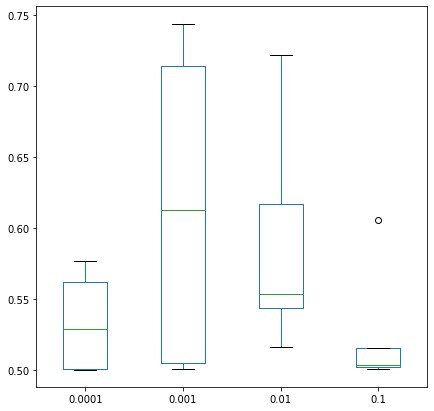

In [60]:
temp_lr = combined_table_lr[(combined_table_lr.loc[:,'label-type']=='0')&\
                            (combined_table_lr.loc[:,'loss-from-logits']=='1')&\
                            (combined_table_lr.AUC>0.5)]
temp_2_lr = pd.pivot_table(temp_lr,
                        values='AUC',
                        columns='learning-rate',
                        index='run_id').reset_index()
temp_2_lr.boxplot(list(temp_2_lr.columns[1:]),
                  figsize=(7,7))#temp_2.columns[2:]
plt.grid(b=None)
plt.show()

In [61]:
stop

NameError: name 'stop' is not defined

# reading in the market data (done automatically atm)

In [ ]:
file

In [ ]:
data

In [ ]:
data

In [ ]:
data.columns

### Dropping ETFS and market indices

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [ ]:
data.Ticker.unique()

In [ ]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [ ]:
data.columns

In [ ]:
data

In [ ]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,ticker_dummies=False)

## Splitting the data

## Adding ticker dummies

In [ ]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

In [ ]:
X.columns

## Constructing our final train/validation sets

In [ ]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

In [ ]:
X_train

In [ ]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


## Pre-processing

In [ ]:
{i:colname for i,colname in enumerate(train_ds.columns)}

In [ ]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing(X_train,X_test,ppdict)

In [ ]:
ppX_train.iloc[:,0].mean(),ppX_train.iloc[:,0].std()

## Prepping for models

In [ ]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

## A Logistic Regression model in TF/Keras

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

In [ ]:
model.evaluate(validate_ds,  val_y, verbose=2)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs